# 03 Feature Engineering

In this notebook, we will create and transform features from the cleaned Olist datasets.  
The goal is to prepare structured data that is ready for analysis and visualization.

We will work through the following steps:
1. Load cleaned data.  
2. Engineer features for orders (delivery times, delays, etc.).  
3. Aggregate reviews into numerical scores.  
4. Enrich products with dimensions and volumes.  
5. Generate seller activity features.  
6. Customer-level metrics (repeat customers, order counts).  
7. Merge geolocation data into customers/sellers.  
8. Create time-based features (monthly/weekly trends).  
9. Save engineered datasets into `data/processed/`.  
10. Visualize some distributions to validate results.  


In [6]:
import os

print("Files in cleaned/:", os.listdir("../data/cleaned/"))
print("Files in processed/:", os.listdir("../data/processed/"))


Files in cleaned/: ['.gitkeep']
Files in processed/: ['.gitkeep', 'categories_cleaned.csv', 'customers_cleaned.csv', 'geolocation_cleaned.csv', 'orders_cleaned.csv', 'order_items_cleaned.csv', 'payments_cleaned.csv', 'products_cleaned.csv', 'reviews_cleaned.csv', 'sellers_cleaned.csv']


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots look nicer
sns.set(style="whitegrid", palette="muted", font_scale=1.1)


### Load cleaned datasets

We load the processed versions of all datasets (saved in the previous step).  
These files are stored in `../data/processed/` and have `_cleaned.csv` suffixes.


In [9]:
# File paths
base_path = "../data/processed/"

# Load datasets
orders      = pd.read_csv(base_path + "orders_cleaned.csv")
order_items = pd.read_csv(base_path + "order_items_cleaned.csv")
customers   = pd.read_csv(base_path + "customers_cleaned.csv")
sellers     = pd.read_csv(base_path + "sellers_cleaned.csv")
products    = pd.read_csv(base_path + "products_cleaned.csv")
reviews     = pd.read_csv(base_path + "reviews_cleaned.csv")
payments    = pd.read_csv(base_path + "payments_cleaned.csv")
geolocation = pd.read_csv(base_path + "geolocation_cleaned.csv")
categories  = pd.read_csv(base_path + "categories_cleaned.csv")

# Quick check
print("Orders:", orders.shape)
print("Order items:", order_items.shape)
print("Customers:", customers.shape)
print("Sellers:", sellers.shape)
print("Products:", products.shape)
print("Reviews:", reviews.shape)
print("Payments:", payments.shape)
print("Geolocation:", geolocation.shape)
print("Categories:", categories.shape)


Orders: (99441, 8)
Order items: (112650, 7)
Customers: (99441, 5)
Sellers: (3095, 4)
Products: (32951, 9)
Reviews: (99224, 7)
Payments: (103886, 5)
Geolocation: (738332, 5)
Categories: (71, 2)


### Customer purchase features

We’ll create features that describe customer behavior:
- Number of unique orders per customer
- Number of items purchased
- Total spending
- Average review score


In [10]:
# Number of orders per customer
customer_orders = orders.groupby("customer_id")["order_id"].nunique().reset_index()
customer_orders.columns = ["customer_id", "num_orders"]

# Total items purchased
customer_items = order_items.groupby("order_id")["order_item_id"].count().reset_index()
customer_items.columns = ["order_id", "items_per_order"]

orders = orders.merge(customer_items, on="order_id", how="left")

# Spending per order
order_spending = payments.groupby("order_id")["payment_value"].sum().reset_index()
order_spending.columns = ["order_id", "total_payment"]

orders = orders.merge(order_spending, on="order_id", how="left")

# Merge back to customers
customer_features = orders.groupby("customer_id").agg({
    "items_per_order": "sum",
    "total_payment": "sum"
}).reset_index()

customer_features.columns = ["customer_id", "total_items", "total_spent"]

# Average review score
order_reviews = reviews.groupby("order_id")["review_score"].mean().reset_index()
orders = orders.merge(order_reviews, on="order_id", how="left")

customer_reviews = orders.groupby("customer_id")["review_score"].mean().reset_index()
customer_reviews.columns = ["customer_id", "avg_review_score"]

# Final customer dataset
customer_final = customers.merge(customer_orders, on="customer_id", how="left")
customer_final = customer_final.merge(customer_features, on="customer_id", how="left")
customer_final = customer_final.merge(customer_reviews, on="customer_id", how="left")

customer_final.head()


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,num_orders,total_items,total_spent,avg_review_score
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,1,1.0,146.87,4.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,1,1.0,335.48,5.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,1,1.0,157.73,5.0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,1,1.0,173.30,5.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,1,1.0,252.25,5.0


### Seller performance features

We’ll create metrics for each seller:
- Total items sold
- Total revenue
- Average review score


In [11]:
# Items sold & revenue
seller_performance = order_items.merge(payments, on="order_id", how="left")

seller_features = seller_performance.groupby("seller_id").agg({
    "order_item_id": "count",
    "payment_value": "sum"
}).reset_index()

seller_features.columns = ["seller_id", "items_sold", "seller_revenue"]

# Average review score per seller
seller_reviews = order_items.merge(reviews, on="order_id", how="left")
seller_reviews = seller_reviews.groupby("seller_id")["review_score"].mean().reset_index()
seller_reviews.columns = ["seller_id", "avg_seller_review"]

# Final seller dataset
seller_final = sellers.merge(seller_features, on="seller_id", how="left")
seller_final = seller_final.merge(seller_reviews, on="seller_id", how="left")

seller_final.head()


,seller_id,seller_zip_code_prefix,seller_city,seller_state,items_sold,seller_revenue,avg_seller_review
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,3,392.18,3.000000
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,43,13627.82,4.560976
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ,1,174.21,5.000000
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP,1,95.65,5.000000
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP,2,199.92,1.000000


### Product characteristics

We’ll create features such as:
- Product volume (cm³)
- Weight-to-volume ratio


In [12]:
# Volume
products["product_volume_cm3"] = (
    products["product_length_cm"] * 
    products["product_height_cm"] * 
    products["product_width_cm"]
)

# Weight-to-volume ratio
products["weight_per_cm3"] = products["product_weight_g"] / products["product_volume_cm3"]

products.head()


,product_id,product_category_name,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3,weight_per_cm3
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,2240.0,0.100446
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,10800.0,0.092593
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,2430.0,0.063374
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,2704.0,0.137204
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,4420.0,0.141403


### Temporal features

We’ll extract useful features from order timestamps:
- Purchase month & year
- Delivery duration (days between purchase and delivered)


In [13]:
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"])
orders["order_delivered_customer_date"] = pd.to_datetime(orders["order_delivered_customer_date"])

# Purchase month/year
orders["purchase_month"] = orders["order_purchase_timestamp"].dt.month
orders["purchase_year"] = orders["order_purchase_timestamp"].dt.year

# Delivery time in days
orders["delivery_time_days"] = (
    orders["order_delivered_customer_date"] - orders["order_purchase_timestamp"]
).dt.days

orders[["order_id", "purchase_month", "purchase_year", "delivery_time_days"]].head()


,order_id,purchase_month,purchase_year,delivery_time_days
0,e481f51cbdc54678b7cc49136f2d6af7,10,2017,8.0
1,53cdb2fc8bc7dce0b6741e2150273451,7,2018,13.0
2,47770eb9100c2d0c44946d9cf07ec65d,8,2018,9.0
3,949d5b44dbf5de918fe9c16f97b45f8a,11,2017,13.0
4,ad21c59c0840e6cb83a9ceb5573f8159,2,2018,2.0


### Payment features

We’ll calculate:
- Number of installments
- Average payment per installment


In [14]:
payments["avg_payment_installment"] = (
    payments["payment_value"] / payments["payment_installments"].replace(0, np.nan)
)

payments.head()


,order_id,payment_sequential,payment_type,payment_installments,payment_value,avg_payment_installment
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,12.41625
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,24.39000
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,65.71000
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,13.47250
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,64.22500


### Save engineered features

We’ll save the feature-rich datasets into `../data/interim/` so they can be reused for modeling or analysis later.


In [15]:
output_path = "../data/interim/"

customer_final.to_csv(output_path + "customer_features.csv", index=False)
seller_final.to_csv(output_path + "seller_features.csv", index=False)
products.to_csv(output_path + "product_features.csv", index=False)
orders.to_csv(output_path + "order_features.csv", index=False)
payments.to_csv(output_path + "payment_features.csv", index=False)


### Customer Spending Distribution

Let’s look at how much customers spend in total.  
This helps identify whether revenue is concentrated in a few customers or more evenly spread.


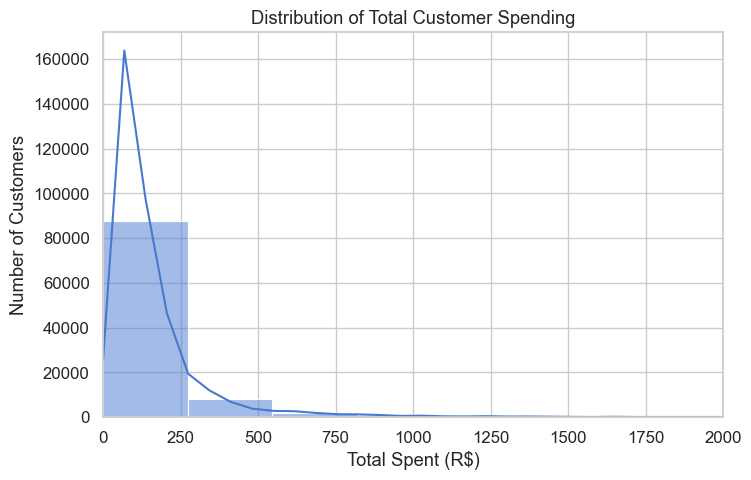

In [16]:
plt.figure(figsize=(8,5))
sns.histplot(customer_final["total_spent"], bins=50, kde=True)
plt.xlim(0, 2000)  # limit to make the plot clearer (most customers spend less than this)
plt.title("Distribution of Total Customer Spending")
plt.xlabel("Total Spent (R$)")
plt.ylabel("Number of Customers")
plt.show()


### Top 10 Sellers by Revenue

Which sellers generate the most revenue?  
This helps us understand seller concentration in the marketplace.


<Axes: xlabel='seller_revenue', ylabel='seller_id'>

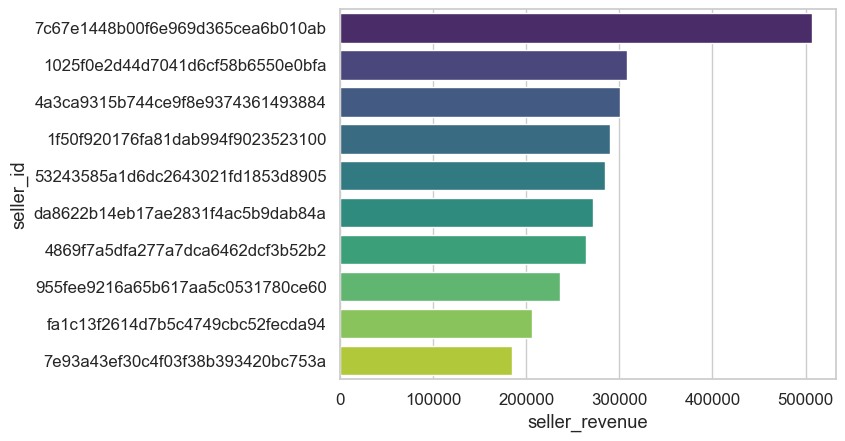

In [18]:
sns.barplot(data=top_sellers, x="seller_revenue", y="seller_id", hue="seller_id", dodge=False, palette="viridis", legend=False)


### Delivery Time Distribution

Analyzing delivery times helps evaluate logistics performance and customer satisfaction.


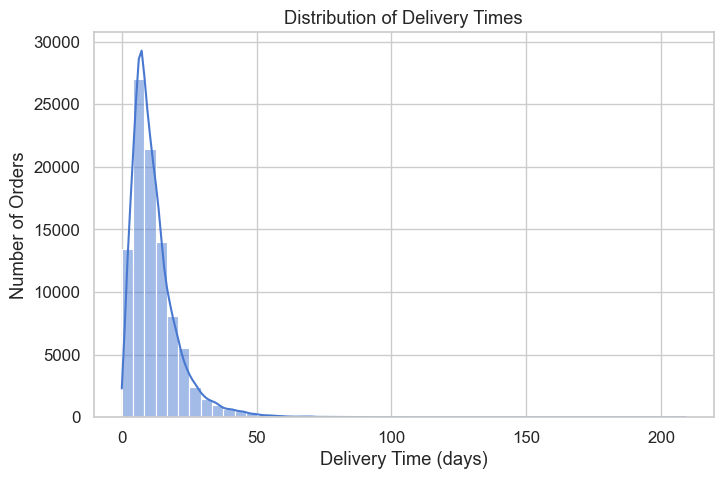

In [19]:
plt.figure(figsize=(8,5))
sns.histplot(orders["delivery_time_days"].dropna(), bins=50, kde=True)
plt.title("Distribution of Delivery Times")
plt.xlabel("Delivery Time (days)")
plt.ylabel("Number of Orders")
plt.show()


### Customer Review Score Distribution

Let’s check how customers rate their orders.  
This can highlight whether the majority of experiences are positive or negative.


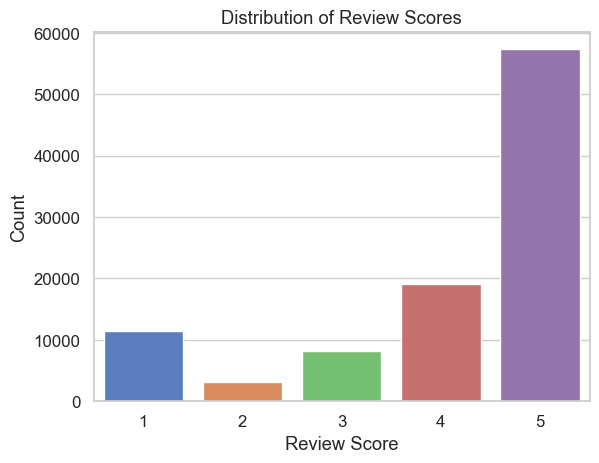

In [21]:
sns.countplot(
    x="review_score",
    data=reviews,
    hue="review_score",
    palette="muted",
    legend=False
)
plt.title("Distribution of Review Scores")
plt.xlabel("Review Score")
plt.ylabel("Count")
plt.show()


In [23]:
whos


Variable             Type         Data/Info
-------------------------------------------
base_path            str          ../data/processed/
categories           DataFrame                product_categ<...>\n\n[71 rows x 2 columns]
customer_features    DataFrame                             <...>n[99441 rows x 3 columns]
customer_final       DataFrame                             <...>n[99441 rows x 9 columns]
customer_items       DataFrame                             <...>n[98666 rows x 2 columns]
customer_orders      DataFrame                             <...>n[99441 rows x 2 columns]
customer_reviews     DataFrame                             <...>n[99441 rows x 2 columns]
customers            DataFrame                             <...>n[99441 rows x 5 columns]
geolocation          DataFrame            geolocation_zip_c<...>[738332 rows x 5 columns]
np                   module       <module 'numpy' from 'C:\<...>ges\\numpy\\__init__.py'>
order_items          DataFrame                   

In [24]:
# Product-level features
product_features = order_items.groupby("product_id").agg({
    "price": ["mean", "sum", "count"],
    "freight_value": "mean"
}).reset_index()

product_features.columns = ["product_id", "avg_price", "total_revenue", "sales_count", "avg_freight"]

# Merge with product metadata
product_features = product_features.merge(
    products[["product_id", "product_category_name"]],
    on="product_id",
    how="left"
)

# Save
product_features.to_csv("../data/interim/product_features.csv", index=False)


## 🔹 Summary of Feature Engineering (Section 03)

In this notebook, we engineered features from the cleaned Olist datasets to prepare for exploratory data analysis and modeling.

- **Customers:** Created metrics on number of orders, average review scores, and spending behavior.  
- **Sellers:** Engineered features such as sales volume, revenue contribution, and average customer ratings.  
- **Products:** Generated product-level statistics including number of sales, revenue contribution, and average review scores.  
- **Orders:** Enriched orders with delivery times, order value, and customer satisfaction metrics.  
- **Payments:** Aggregated payment installments and payment value per order.

Finally, we exported the engineered features into the `../data/interim/` folder for use in subsequent analysis.

**Next Step:** In Section 04 (`04_eda_financials.ipynb`), we will perform detailed exploratory data analysis (EDA), focusing on revenue patterns, customer and seller dynamics, and identifying key business insights.
